# Item-Based Collaborative Filtering Movielens

This notebook explores the concept of Item-Based Collaborative Filtering, an increasingly popular recommendation algorithm. Large enterprises, recognizing the benefits of personalized recommendations, are increasingly investing in research and implementation of recommender systems. How it works?? The algorithm works by finding the similarity between items based on the ratings users have given them. The assumption here is that if two items are similar, a user who liked one item would also likely enjoy the other.

`This notebook is made by Sander van Duin`

This notebook will also guide you through all the coding work that is needed to build (basic) recommender systems. The aim of this notebook is to investigate the application of collaborative filtering techniques for Movielens.      



<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">0. Importing Packages</h2>
</div>

In [2]:
import pandas as pd
import numpy as np
from pyarrow import parquet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import issparse
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack
from collections import Counter

| Package                                      | Description                                                                                       | Benefit                                                                                                   |
|----------------------------------------------|---------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **pandas**                                   | A library providing high-performance, easy-to-use data structures, and data analysis tools.       | Facilitates data manipulation and analysis, making data exploration and cleaning efficient.               |
| **numpy**                                    | A fundamental package for scientific computing with Python, supporting large, multi-dimensional arrays and matrices. | Offers comprehensive mathematical functions, enabling complex numerical operations with ease.             |
| **pyarrow.parquet**                          | A part of PyArrow for reading and writing the Parquet format, efficiently storing tabular data in columnar format. | Enables high-performance data storage and retrieval, supporting efficient compression and encoding schemes. |
| **matplotlib**                               | A plotting library for creating static, interactive, and animated visualizations in Python.      | Provides a versatile way to visualize data, with extensive support for custom plots and graphs.           |
| **sklearn.model_selection.train_test_split** | A function for splitting dataset arrays into random train and test subsets.                       | Essential for evaluating the performance of a model by training on one subset and testing on another.      |
| **scipy.sparse.csr_matrix**                  | A SciPy class for a sparse matrix in Compressed Sparse Row format.                                | Saves memory and improves performance for operations on sparse matrices, which have a lot of zeros.       |
| **sklearn.metrics.mean_squared_error**       | A metric to measure the average of the squares of the errors or deviations.                       | Useful for assessing the accuracy of a regression model, penalizing larger errors more than smaller ones. |
| **sklearn.metrics.mean_absolute_error**      | A metric to measure the mean absolute difference between predicted and actual values.             | Provides a straightforward way to understand the average error magnitude a model may have.                |
| **scipy.sparse.issparse**                    | A function to check whether a matrix is a sparse matrix.                                          | Allows for conditional operations based on the storage scheme of the matrix, optimizing performance.      |
| **fuzzywuzzy.process**                       | A part of FuzzyWuzzy, a library for string matching, allowing for approximate matches.            | Helps in matching similar strings, useful in tasks like data cleaning and validation where exact matches are not possible. |
| **sklearn.neighbors.NearestNeighbors**       | A class for unsupervised learner for implementing neighbor searches.                               | Facilitates finding the nearest neighbors of a point, useful in algorithms like k-nearest neighbors for both classification and regression. |
| **scipy.sparse vstack**                      | Vertical stacking (vstack) if the matrices have the same number of columns but different numbers of rows.                         | Instead of using the + operator, which requires matrices of the same shape, you can use vertical stacking if the matrices have the same number of columns but different numbers of rows         
| Collections Counter                          | This module is used to count the occurrences of elements within an iterable object. It returns a dictionary-like object where elements of the iterable are the keys, and their corresponding counts are the values. | Efficient Counting, Automatic zero count, and useful to analyze the occurences within elements



<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">1. Preparing the Dataset</h2>
</div>

## 1.1 Loading the datasets

### Function: `loading_datasets`

This function is designed to load a movie dataset from a specified path, focusing on a file in the Parquet format. The steps followed in this function are outlined below:

#### 1. **Specify the File Path:**
- The function accepts a base path as input, which is expected to be the directory where the dataset is stored. The filename `'movielens_item_pers1.parquet'` is appended to this base path to form the full path to the dataset.
#### 2. **Read the Dataset:**
- Pandas is used to read the Parquet file using the `pyarrow` engine. This method efficiently loads the dataset into a DataFrame `df`, accommodating large datasets.
#### 3. **Dataset Dimensions & Unique Elements Analysis:**
- The function prints the dimensions of the loaded DataFrame to provide an immediate understanding of its scale, displaying the total number of rows and columns.
- It calculates and prints the count of unique movies (`itemid`), users (`userid`), and ratings (`rating`) found within the dataset.
- Additionally, it computes the number of unique genres (or genre combinations) available in the dataset, which are going to needed later on



In [3]:
def loading_datasets(base_path):
    # Load the dataset
    parquet_file = base_path + 'movielens_item_pers1.parquet'
    # 'pyarrow' is a fast and efficient library for reading and writing data in Parquet format.
    df = pd.read_parquet(parquet_file, engine='pyarrow')

    print('The dimensions of the movies dataset are:', df.shape)

    # Check the number of unique items and users
    unique_items = df['itemid'].nunique()
    unique_users = df['userid'].nunique()
    unique_ratings = df['rating'].nunique()
    
    # Print the results
    print(f"The number of unique movies in the movies dataset is {unique_items}")
    print(f"The number of unique users in the movies dataset is {unique_users}")
    print(f"The number of unique ratings in the movies dataset is {unique_ratings}")
    print(f"The number of unique genres (genre combinations) in the movies dataset is {df['genre'].nunique()}")

    return df

base_path = '/Users/sandervanduin/Desktop/CSV_parquet/'
df = loading_datasets(base_path)
df.head(5)

The dimensions of the movies dataset are: (24988355, 6)
The number of unique movies in the movies dataset is 58675
The number of unique users in the movies dataset is 162541
The number of unique ratings in the movies dataset is 10
The number of unique genres (genre combinations) in the movies dataset is 1621


,userid,itemid,rating,title,genre,year
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
1,3,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
2,4,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
3,5,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
4,7,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994


# 1.2 Data Filtering
### & Sampling (Optional)


The `data_filtering` function refines the dataset by removing infrequent users and movies with few ratings. This ensures that subsequent analysis is based on reliable and significant interaction data, improving the quality of insights and recommendations.

#### Function Overview

The function filters the dataset in two key steps:

1. **User Activity Filter**: It excludes users who have rated a lower percentage of movies than the specified threshold. This focuses the dataset on active users.
2. **Movie Popularity Filter**: It removes movies that have not received a minimum number of ratings, concentrating on well-reviewed movies.

#### Parameters
- `mimimum_percentage_movies_user_rated`: The minimum percentage of movies a user must have rated to be included in the dataset.
- `minimum_ratings_per_movie`: The minimum number of ratings a movie must have to remain in the dataset.

#### Sample
- `Sample`: If you want to experiment with a small sample, switch to `TRUE`



In [4]:
import pandas as pd

def data_filtering(df, mimimum_percentage_movies_user_rated=0.02, minimum_ratings_per_movie=50):

    # Count the number of ratings for each movie and each user
    ratings_per_movie = df.groupby('itemid').size().reset_index(name='ratings_per_movie')
    ratings_per_user = df.groupby('userid').size().reset_index(name='number_rated')
    # Filter out users who have rated less than the minimum percentage of movies
    eligible_users = ratings_per_user[ratings_per_user['number_rated'] / ratings_per_movie.shape[0] > mimimum_percentage_movies_user_rated]
    df_filtered_users = df[df['userid'].isin(eligible_users['userid'])]
    # Filter out movies that have been rated by less than the threshold number of users
    eligible_movies = ratings_per_movie[ratings_per_movie['ratings_per_movie'] >= minimum_ratings_per_movie]
    df_filtered = df_filtered_users[df_filtered_users['itemid'].isin(eligible_movies['itemid'])]
    # Print the results
    print(f'Removing users who have rated less than {mimimum_percentage_movies_user_rated*100}% of all movies')
    print(f'Filtered dataset size after removing less active users: {df_filtered_users.shape[0]}\n')
    print(f'Removing movies that have been rated by fewer than {minimum_ratings_per_movie} users')
    print(f'Filtered dataset size after removing less rated movies: {df_filtered.shape[0]}\n')
    
    return df_filtered

# You can now call the filter_data function with sample_df as an argument.
df_filtered = data_filtering(df, mimimum_percentage_movies_user_rated=0.02, minimum_ratings_per_movie=50)

########################

# For experimenting with a smaller dataset, you can sample a fraction of the filtered dataset
# This will reduce the time it takes to run the codes

sampling = False

if sampling == True:
    df_filtered = df_filtered.sample(frac=0.1, random_state=42)

display((df_filtered.head(5)))
print('The dimensions of the sampled dataset are:', df_filtered.shape)

Removing users who have rated less than 2.0% of all movies
Filtered dataset size after removing less active users: 3245471

Removing movies that have been rated by fewer than 50 users
Filtered dataset size after removing less rated movies: 3045632



,userid,itemid,rating,title,genre,year
90,187,296,4.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
261,548,296,4.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
362,757,296,3.5,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
382,803,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
405,847,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994


The dimensions of the sampled dataset are: (3045632, 6)


## 1.3 Creating an Item-User Matrix
###  & Creating Dictionaries and Mappings for Movie Title and Genre

This section outlines the process of preparing the dataset for an item-based collaborative filtering approach. The process involves calculating the unique users and items, establishing mappings between user and item IDs to matrix indices, and creating a sparse matrix representing the item-user interactions.

## Dataset Preparation for Collaborative Filtering

**Step 1: Identify Unique Users and Items**
First, we calculate the unique users and items in the dataset to understand the dimensions of our user-item interaction matrix.
```python
num_users = sorted(...
num_items = sorted(...
```
This step is important for the next phase, where we will map these IDs to specific indices in our matrix.

**Step 2: Create ID-to-Index Mappings**
To facilitate matrix operations, we map user and item IDs to specific indices. This mapping simplifies accessing and updating the matrix based on user/item interactions.
```python
user_to_index = {user_id: ...
item_to_index = {item_id: ...
```
These mappings are important for translating between the dataset's IDs and the indices in the computational models.

**Step 3: Auxiliary Dictionaries for Titles and Genres**
For enhancing the interpretability of our recommendations, we create dictionaries to map movie IDs to their titles and genres.
```python
movie_title_dict = {movie_id: title ...
movie_genre_dict = {movie_id: genre ...
```
This allows us to provide more meaningful recommendations by using movie titles and genres instead of abstract IDs.

**Step 4: Construct the Item-User Matrix**
Finally, we construct a sparse matrix representing the item-user interactions. Each row corresponds to an item, each column to a user, and the cell values represent the rating given by a user to an item.
```python
item_user_matrix = csr_matrix(df_filtered.pivot_table(index='itemid', columns='userid', values='rating').fillna(0).values)
```

**Step 5: Validation**
- The validationis to check if the mapping is correct

#### Not using a manually constructed Matrix
- ---> Therefore choosing csr_matrix, imported from scipy.sparse

Due to  memory use and computational efficiency, I decided to not manually construct a sparse matrix. Manually populating a matrix significantly increases memory overhead and processing time, particularly with large datasets.

The approach of using csr_matrix, imported from scipy.sparse it increases memory efficiency by storing only the non-zero elements, and that is especially useful for very large matrices with many zeros like this dataset of Movielens. Moreover, the csr_matrix is able to make fast matrix-vextor multiplications due to the efficient representation of the sparse structure. Additionally, the CSR format significantly enhances the scalability of data processing and Hyperparameter Tuning on the Movielens dataset, enabling the handling of larger datasets and more complex models without compromising performance.



In [5]:
# Determine the number of unique users and items accurately
num_users = sorted(df_filtered['userid'].unique())  # Calculate the number of unique users in the sampled interactions
num_items = sorted(df_filtered['itemid'].unique())  # Calculate the number of unique items (movies) in the sampled interactions

# Establish mappings from IDs to matrix indices
user_to_index = {user_id: index for index, user_id in enumerate(num_users)} # Create a mapping from user IDs to matrix indices
item_to_index = {item_id: index for index, item_id in enumerate(num_items)} # Create a mapping from item IDs to matrix indices
index_to_item = {index: item_id for item_id, index in item_to_index.items()}
index_to_user = {index: user_id for user_id, index in user_to_index.items()}

# Create dictionaries for mapping between indices and titles and genres
movie_title_dict = {movie_id: title for movie_id, title in zip(df_filtered['itemid'], df_filtered['title'])}
movie_genre_dict = {movie_id: genre for movie_id, genre in zip(df_filtered['itemid'], df_filtered['genre'])}

# Initialise lists to store row, column, and data for the sparse matrix
rows = []  
cols = []  
data = []  

# Populate the lists with data
for index, row in df_filtered.iterrows():
    user_index = user_to_index[row['userid']]  # Map the user ID to its corresponding index in the matrix (columns)
    item_index = item_to_index[row['itemid']]  # Map the item ID to its corresponding index in the matrix (rows)
    rating = row['rating']  # Get the rating value
    
    # Append the item index, user index, and rating to their respective lists
    rows.append(item_index)
    cols.append(user_index)
    data.append(rating)

# *** The self made matrix is not going to be used due to the lack of memory and computational time ***

# **** Therefore, the sparse matrix is going to be used ****
item_user_matrix = csr_matrix(df_filtered.pivot_table(index='itemid', columns='userid', values='rating').fillna(0).values)
# print first rows of the matrix
print("First 5 rows of the item-user matrix:")
print(item_user_matrix[:5, :5])


######## Validation checks ########

# The validation has been done because of checking if the mapping is correct

# Validation example to check if the mapping is correct
filtered_movie_id = df_filtered['itemid'].sample(1).iloc[0]
matrix_index = item_to_index[filtered_movie_id]
title = movie_title_dict[filtered_movie_id]
genre = movie_genre_dict[filtered_movie_id]

print("\nValidation example to check if the mapping is correct")
print(f"Sample movie ID: {filtered_movie_id}")
print(f"Matrix index: {matrix_index}")
print(f"Title: {title}")
print(f"Genre: {genre}")

all_movies_covered = all(movieId in movie_title_dict and movieId in movie_genre_dict for movieId in item_to_index.keys())
all_genres_covered = all(genre in movie_genre_dict.values() for genre in movie_genre_dict.values())
print(f"\nAll movies covered in dictionaries: {all_movies_covered}")
print(f"All genres covered in dictionaries: {all_genres_covered}")


First 5 rows of the item-user matrix:
  (0, 0)	3.5
  (0, 1)	4.5
  (0, 2)	4.5
  (0, 3)	3.0
  (0, 4)	5.0
  (1, 0)	3.5
  (1, 1)	4.0
  (1, 2)	4.0
  (1, 3)	3.0
  (2, 0)	3.0

Validation example to check if the mapping is correct
Sample movie ID: 50794
Matrix index: 8515
Title: Smokin' Aces (2006)
Genre: Action|Crime|Drama|Thriller

All movies covered in dictionaries: True
All genres covered in dictionaries: True


## 1.4 Train, Test, Splitting Distribution

- This code is used to display the train, test, and validation sets in a histogram format
- --> This code will not be used in hyperparameter tuning. A seperate train, test, split will be used there

#### The package train_test_split

The `train_test_split` function, part of the `sklearn.model_selection` package, is instrumental in dividing a dataset into two distinct parts: a training set for developing a machine learning model, and a testing set for evaluating its efficacy. This division is carried out randomly according to a predefined ratio, ensuring that both sets are representative of the overall dataset.

`Functionality`:

- It splits the dataset into subsets for both training and evaluation purposes.
- The division ratio between the training and testing datasets can be customized as needed.
- Prior to division, the dataset undergoes a random shuffle to guarantee that the split is unbiased and incorporates randomness.
- The output consists of four arrays: the training input, test input, and training and test lables

`Advantages`:

- It enables effective model validation: By allocating a portion of the data exclusively for testing, it is possible to gauge the model’s performance on data it has not seeb, assessing its predictive power.
- It aids in identifying overfitting: Using a separate test dataset helps uncover instances where the model might memorize the training data rather than learning general patterns, thus ensuring the model's utility with new data.
- It supports fine-tuning of hyperparameters: By setting aside a test dataset, the function allows for the experimentation with various model settings to determine the optimal configuration, enhancing model performance on unseen data.

(9210, 1803)
(1974, 1803)
(1974, 1803)


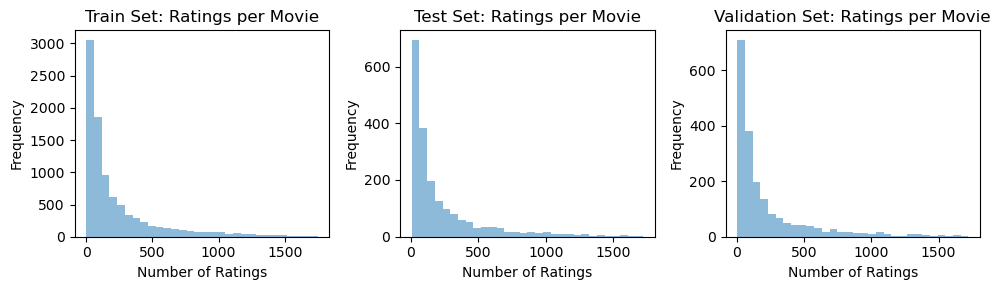

In [6]:
# Split the sparse matrix into 70% train and 30% temporary data (which will be further split into validation and test)
train_data_plot, temp_data = train_test_split(item_user_matrix, test_size=0.30, random_state=42)
# Split the temporary data equally into validation and test sets (50% each, amounting to 15% of the original data each)
val_data_plot, test_data_plot = train_test_split(temp_data, test_size=0.50, random_state=42)

# Print the shapes of the training, testing, and validation sets
print(train_data_plot.shape)
print(test_data_plot.shape)
print(val_data_plot.shape)

# Function to plot histograms
def plot_distribution(data, title):
    plt.hist(data, bins=30, alpha=0.5)
    plt.title(title)
    plt.xlabel('Number of Ratings')
    plt.ylabel('Frequency')

# Count the number of non-zero ratings for each movie
train_ratings_per_movie = train_data_plot.getnnz(axis=1)
test_ratings_per_movie = test_data_plot.getnnz(axis=1)
val_ratings_per_movie = val_data_plot.getnnz(axis=1)

# Plot histograms for number of ratings per movie for train, test, and validation sets
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_distribution(train_ratings_per_movie, 'Train Set: Ratings per Movie')
plt.subplot(1, 3, 2)
plot_distribution(test_ratings_per_movie, 'Test Set: Ratings per Movie')
plt.subplot(1, 3, 3)
plot_distribution(val_ratings_per_movie, 'Validation Set: Ratings per Movie')
plt.tight_layout()
plt.show()



<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">2. Item Based Prediction Models</h2>
</div>


This chapter will focus on building the item (movie) recommendation models
- There is one model who only predicts ratings based on the weighted sum of ratings from top-K similar movies, based on similarity scores
- There are two recommendation model which also predict ratings

This chapter will explore item-based collaborative filtering as a method for recommending movies by leveraging the similarities between items (movies) themselves, rather than user-user comparisons. It seeks to demonstrate how this approach can provide personalized movie recommendations by predicting user ratings with a focus on the underlying patterns within the movie dataset.

## 2.1 Simple predicted rating per selected movie for a specific user

For this simple prediction model I used the cosine_similarity package to quickly calculate similarities between items. In the recommender models I will not use this package. 
- `from sklearn.metrics.pairwise import cosine_similarity` ---> The cosine_similarity function computes the cosine similarity between samples in one or two arrays, measuring the cosine of the angle between vectors in a multidimensional space. This metric, ranging from -1 to 1, is widely used in machine learning to assess how similar two items are based on their features, with 1 indicating identical directionality.

`predict_rating Function`
- **Purpose:** Predicts ratings for a randomly selected movie and user by leveraging item similarities. It embodies the essence of collaborative filtering by considering how similar users rated the movie to infer a targeted prediction.
Process:
- **Random Selection**: Chooses a movie and a user at random to simulate a prediction scenario.
- **Similarity Retrieval**: Extracts cosine similarities for the selected movie against all others in the dataset.
- **Top-K Similarity Selection**: Identifies the top-K similar movies to the selected one, ensuring the prediction is based on the most relevant comparisons.
- **Rating Prediction**: Calculates the predicted rating using a weighted sum of ratings from the top-K similar movies, adjusted by their similarity scores. This method intuitively captures the premise that more similar movies should have a greater influence on the prediction.
- **Fallback Strategy**: Implements a fallback mechanism to use the average rating of the selected movie if it's unrated by the user. This pragmatic approach ensures a prediction is always provided, enhancing user experience by avoiding null responses.

In [6]:
def calculate_similarity (item_user_matrix):
    # Compute the cosine similarity between all items
    item_similarity = cosine_similarity(item_user_matrix, dense_output=False)
    return item_similarity

def predict_rating(item_user_matrix, item_to_index, movie_title_dict, k=10):
    # Compute the cosine similarity between all items
    item_similarity = cosine_similarity(item_user_matrix, dense_output=False)

    # Select a movie and user for prediction
    selected_movie_index = np.random.choice(item_user_matrix.shape[0])
    user_index = np.random.choice(item_user_matrix.shape[1])

    # Reverse-map selected movie index to movie ID
    selected_movie_id = index_to_item[selected_movie_index]

    # Look up the movie title
    selected_movie_title = movie_title_dict.get(selected_movie_id, "Unknown Title")

    print(f"Selected Movie Index: {selected_movie_index}")
    print(f"Selected Movie ID: {selected_movie_id}")
    print(f"Selected Movie Title: {selected_movie_title}")
    print(f"User Index: {user_index}")

    # Get the similarities for the selected movie
    similarities = item_similarity[selected_movie_index]

    # Sort movies by similarity and select the top k
    top_k_indices = np.argsort(similarities)[-k:]

    # Initialize variables for weighted sum and similarity sum
    weighted_sum = 0
    similarity_sum = 0

    for index in top_k_indices:
        user_rating = item_user_matrix[index, user_index]
        # Skip movies that the user has not rated
        if user_rating > 0:
            weighted_sum += similarities[index] * user_rating
            similarity_sum += similarities[index]

    # Compute the predicted rating
    if np.all(similarity_sum.toarray() > 0):
        predicted_rating = weighted_sum / similarity_sum
    else:
        # Fallback: Use the average rating for the selected movie
        movie_ratings = item_user_matrix[selected_movie_index, item_user_matrix[selected_movie_index].nonzero()[1]]
        predicted_rating = np.mean(movie_ratings.toarray()) if movie_ratings.getnnz() > 0 else np.nan

    print(f"\nPredicted rating for movie {selected_movie_index} by user {user_index}: {predicted_rating:.2f}")


# Call the function
predict_rating(item_user_matrix, item_to_index=item_to_index, movie_title_dict=movie_title_dict, k=10)



Selected Movie Index: 9012
Selected Movie ID: 59103
Selected Movie Title: Forbidden Kingdom, The (2008)
User Index: 1164

Predicted rating for movie 9012 by user 1164: 3.06


## 2.2 Recommender prediction model 1 (with input function)


This code implements an item-based collaborative filtering approach to recommend movies. It utilizes cosine similarity to measure the similarity between movies and predicts ratings using a combination of global averages, user biases, and item biases.

**Key Components:**

- `Item_Item_matrix`: Custom function item_item_matrix calculates the cosine similarity between two vectors, representing the similarity between movies based on user ratings.
- `Bias Calculation`: Computes global average rating, user biases, and item biases to adjust predictions and account for systematic tendencies in the data.
- `Rating Prediction`: The predict_ratings function predicts ratings for a set of movies (top-k similar items) for a given user, incorporating biases and similarities to generate personalized recommendations.

**Recommendation Process:**

1. Selects a movie and calculates similarities to all other movies.
2. Identifies the top-k most similar movies.
3. Predicts ratings for these movies for a specific user, using a weighted sum of the user's ratings adjusted by biases and similarity scores.

**Outcome Display:**

- Lists movies previously seen by the user related to the selected movie.
- Shows the top-k recommended movies based on the calculated predictions, including their titles, genres, and the predicted ratings.
- This approach enhances the recommendation process by providing more personalized and careful movie suggestions, leveraging detailed user-item interaction data and adjusting for individual and item-specific biases.

As an extra I put the `find_movie_by_title`function, which uses `fuzzy string` (package) matching to identify and return the most similar movie title from the dataset based on a given search query. This enhances user experience by allowing for flexible movie searches, even when the exact titles are not known or are misspelled.

- The `fuzzywuzzy` package is a tool for string matching that uses Levenshtein Distance to calculate the differences between sequences. It provides easy-to-use functions to compare strings and determine similarity, allowing for partial matches and typo tolerance in text comparison. This makes it particularly useful for searching titles.

- -----> Levenshtein Distance is a measure of the minimum number of single-character edits required to change one string into another, including insertions, deletions, or substitutions. The Levenshtein Distance was introduced by the Soviet mathematician Vladimir Levenshtein in 1965. He described it as a metric to measure the difference between two sequences, which could be strings of characters, words, or any other ordered elements.

In [7]:
# Define the cosine similarity function
def item_item_matrix(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    return dot_product / norm_product if norm_product != 0 else 0

# Define the user and item biases
global_avg = np.mean(item_user_matrix[item_user_matrix > 0])
user_biases = {user_index: np.mean(item_user_matrix[user_index, :][item_user_matrix[user_index, :] > 0]) - global_avg for user_index in range(item_user_matrix.shape[0])}
item_biases = {item_index: np.mean(item_user_matrix[:, item_index][item_user_matrix[:, item_index] > 0]) - global_avg for item_index in range(item_user_matrix.shape[1])}


def predict_ratings(item_user_matrix, user_index, top_k_items, item_to_index, index_to_item, global_avg, user_biases, item_biases):
    """Predict ratings for the top k recommended items for a given user, incorporating global average, user bias, and item bias."""
    predicted_ratings = []

    for item_index, similarity in top_k_items:
        if item_index in index_to_item:
            movie_id = index_to_item[item_index]
            item_matrix_index = item_to_index.get(movie_id, -1)
            
            if 0 <= item_matrix_index < item_user_matrix.shape[1]:
                # Get the actual rating
                user_rating = item_user_matrix[user_index, item_matrix_index]
                # Check if the user has rated the item
                if user_rating > 0:
                    # Incorporate biases into the predicted rating
                    user_bias = user_biases.get(user_index, 0)
                    item_bias = item_biases.get(item_matrix_index, 0)
                    # Calculate the weighted rating
                    weighted_rating = global_avg + user_bias + item_bias + (similarity * (user_rating - (global_avg + user_bias + item_bias)))
                    predicted_ratings.append((movie_id, weighted_rating))
                else:
                    # Predict rating based on global average and biases if the user hasn't rated the item
                    predicted_ratings.append((movie_id, global_avg + user_biases.get(user_index, 0) + item_biases.get(item_matrix_index, 0)))
            else:
                # Default to global average if no rating information is available
                predicted_ratings.append((movie_id, global_avg))
    
    return predicted_ratings


def find_movie_by_title(movie_title_dict, search_query):
    titles = list(movie_title_dict.values())
    best_match = process.extractOne(search_query, titles)
    return best_match


def recommend_movies(item_user_matrix, selected_movie_index, user_index, item_to_index, index_to_item, movie_title_dict, movie_genre_dict, k=10):
    # Fetch the title of the selected movie for the outcome
    selected_movie_title = movie_title_dict.get(index_to_item[selected_movie_index], "Unknown Title")

    # Calculate cosine similarity between items
    similarities = [(i, item_item_matrix(item_user_matrix[selected_movie_index, :].toarray().flatten(),
                                        item_user_matrix[i, :].toarray().flatten())) for i in range(item_user_matrix.shape[0]) if i != selected_movie_index]
    sorted_items = sorted(similarities, key=lambda x: x[1], reverse=True)
    top_k_items = sorted_items[:k]

    # Predict ratings for the top k items
    predicted_ratings = predict_ratings(item_user_matrix, user_index, top_k_items, item_to_index, index_to_item, global_avg, user_biases, item_biases)
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

    # Display the movies seen by the user related to the selected movie
    movies_seen_indices = item_user_matrix[user_index, :].nonzero()[1]
    movies_seen_titles = [movie_title_dict.get(index_to_item[i], "Unknown Title") for i in movies_seen_indices if i != selected_movie_index][:5]

    print(f"\n5 movies seen by user {user_index} related to the selected movie '{movie_title_dict.get(index_to_item[selected_movie_index], 'Unknown')}':")
    for title in movies_seen_titles:
        print(f"- {title}")

    # Display the outcome
    print(f"\nTop {k} recommended movies based on '{selected_movie_title}' with predicted ratings for user {user_index}:\n")
    for movie_id, predicted_rating in predicted_ratings:
        title = movie_title_dict.get(movie_id, "Unknown Title")
        genre = movie_genre_dict.get(movie_id, "Unknown Genre")
        print(f"ItemID: {movie_id}, Title: \033[1;32m{title}\033[0m, Genre: {genre}, Predicted Rating: \033[1;34m{predicted_rating:.2f}\033[0m")

In [8]:
# user_index = 5
user_index = int(input("Enter a user index: "))
# search_query = "Notebook"
search_query = input("Enter a movie title: ")

best_match_title, score = find_movie_by_title(movie_title_dict, search_query)
# Reverse lookup for movie titles to IDs
movie_id = {title: id for id, title in movie_title_dict.items()}[best_match_title]
selected_movie_index = item_to_index[movie_id]

# Call the recommend_movies function with the found movie index
recommend_movies(item_user_matrix, selected_movie_index, user_index, item_to_index, index_to_item, movie_title_dict, movie_genre_dict, k=10)


5 movies seen by user 5 related to the selected movie 'Forrest Gump (1994)':
- Jumanji (1995)
- Heat (1995)
- Sabrina (1995)
- Tom and Huck (1995)
- Sudden Death (1995)

Top 10 recommended movies based on 'Forrest Gump (1994)' with predicted ratings for user 5:

ItemID: 296, Title: Pulp Fiction (1994), Genre: Comedy|Crime|Drama|Thriller, Predicted Rating: 4.94
ItemID: 1198, Title: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Genre: Action|Adventure, Predicted Rating: 4.91
ItemID: 260, Title: Star Wars: Episode IV - A New Hope (1977), Genre: Action|Adventure|Sci-Fi, Predicted Rating: 4.63
ItemID: 318, Title: Shawshank Redemption, The (1994), Genre: Crime|Drama, Predicted Rating: 4.06
ItemID: 593, Title: Silence of the Lambs, The (1991), Genre: Crime|Horror|Thriller, Predicted Rating: 3.97
ItemID: 1270, Title: Back to the Future (1985), Genre: Adventure|Comedy|Sci-Fi, Predicted Rating: 3.55
ItemID: 1580, Title: Men in Black (a.k.a. MIB) (1997), Genre: 

# 2.3 Recommender prediction model 2 
#### With similarity score and given rating for seen movies by user

Similar to the first Recommender prediction model, but:
- This model displays the given rating for the seen movies for that user
- Shows the highest similarity scores between the chosen movie and the movies seen by the user 

This recommendation model makes it more clear why certain recommendations are made with a certain rating. Because the rating the user gave to their seen movies are taken into account in the predicted rating.

In [9]:
# Define the cosine similarity function
def item_item_matrix(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    return dot_product / norm_product if norm_product != 0 else 0

# Define the user and item biases
global_avg = np.mean(item_user_matrix[item_user_matrix > 0])
user_biases = {user_index: np.mean(item_user_matrix[user_index, :][item_user_matrix[user_index, :] > 0]) - global_avg for user_index in range(item_user_matrix.shape[0])}
item_biases = {item_index: np.mean(item_user_matrix[:, item_index][item_user_matrix[:, item_index] > 0]) - global_avg for item_index in range(item_user_matrix.shape[1])}

def predict_ratings(item_user_matrix, user_index, top_k_items, item_to_index, index_to_item, global_avg, user_biases, item_biases):
    """Predict ratings for the top k recommended items for a given user, incorporating global average, user bias, and item bias."""
    predicted_ratings = []

    for item_index, similarity in top_k_items:
        if item_index in index_to_item:
            movie_id = index_to_item[item_index]
            item_matrix_index = item_to_index.get(movie_id, -1)
            
            if 0 <= item_matrix_index < item_user_matrix.shape[1]:
                # Get the actual rating
                user_rating = item_user_matrix[user_index, item_matrix_index]
                # Check if the user has rated the item
                if user_rating > 0:
                    # Incorporate biases into the predicted rating
                    user_bias = user_biases.get(user_index, 0)
                    item_bias = item_biases.get(item_matrix_index, 0)
                    # Calculate the weighted rating
                    weighted_rating = global_avg + user_bias + item_bias + (similarity * (user_rating - (global_avg + user_bias + item_bias)))
                    predicted_ratings.append((movie_id, weighted_rating))
                else:
                    # Predict rating based on global average and biases if the user hasn't rated the item
                    predicted_ratings.append((movie_id, global_avg + user_biases.get(user_index, 0) + item_biases.get(item_matrix_index, 0)))
            else:
                # Default to global average if no rating information is available
                predicted_ratings.append((movie_id, global_avg))
    
    return predicted_ratings


def recommend_movies1(item_user_matrix, selected_movie_index, user_index, item_to_index, index_to_item, movie_title_dict, movie_genre_dict, k=10):
    # Fetch the title of the selected movie for the outcome
    selected_movie_title = movie_title_dict.get(index_to_item[selected_movie_index], "Unknown Title")

    # Calculate cosine similarity between items
    similarities = [(i, item_item_matrix(item_user_matrix[selected_movie_index, :].toarray().flatten(),
                                        item_user_matrix[i, :].toarray().flatten())) for i in range(item_user_matrix.shape[0]) if i != selected_movie_index]
    sorted_items = sorted(similarities, key=lambda x: x[1], reverse=True)
    top_k_items = sorted_items[:k]

    # Predict ratings for the top k items
    predicted_ratings = predict_ratings(item_user_matrix, user_index, top_k_items, item_to_index, index_to_item, global_avg, user_biases, item_biases)
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:10]

    # Assuming 'similarities' is a list of tuples (movie_index, similarity_score) for all movies
    similarities_dict = dict(similarities)  # Convert the list of tuples into a dictionary for easy access

    # Display the movies seen by the user related to the selected movie along with their given ratings
    movies_seen_indices = item_user_matrix[user_index, :].nonzero()[1]
    movies_seen_info = []

    for i in movies_seen_indices:
        if i != selected_movie_index:  # Skip the selected movie
            movie_id = index_to_item[i]  # Convert matrix index to movieId
            title = movie_title_dict.get(movie_id, "Unknown Title")  # Fetch the title from dictionary
            given_rating = item_user_matrix[user_index, i]  # Fetch the given rating by the user
            similarity_score = similarities_dict.get(i, 0)  # Get the similarity score from the dictionary, default to 0 if not found
            movies_seen_info.append((title, given_rating, similarity_score))

    # Sort the seen movies by their similarity scores
    movies_seen_info = sorted(movies_seen_info, key=lambda x: x[2], reverse=True)[:5]  # Sort by similarity score, limiting to 5

    print(f"5 movies seen by user {user_index} related to the selected movie '{movie_title_dict.get(index_to_item[selected_movie_index], 'Unknown')}':\n")
    for title, rating, similarity in movies_seen_info:
        print(f"- {title}, Given Rating: {rating}, Similarity Score: {similarity:.2f}")


    # Display the outcome
    print(f"\nTop 10 recommended movies based on '{selected_movie_title}' with predicted ratings for user {user_index}:\n")
    for movie_id, predicted_rating in predicted_ratings:
        title = movie_title_dict.get(movie_id, "Unknown Title")
        genre = movie_genre_dict.get(movie_id, "Unknown Genre")
        print(f"ItemID: {movie_id}, Title: \033[1;32m{title}\033[0m, Genre: {genre}, Predicted Rating: \033[1;34m{predicted_rating:.2f}\033[0m")


In [10]:
# Example usage
selected_movie_index =  0
user_index =  4
recommend_movies1(item_user_matrix, selected_movie_index, user_index, item_to_index, index_to_item, movie_title_dict, movie_genre_dict, k=20)

5 movies seen by user 4 related to the selected movie 'Toy Story (1995)':

- Star Wars: Episode IV - A New Hope (1977), Given Rating: 4.0, Similarity Score: 0.92
- Star Wars: Episode V - The Empire Strikes Back (1980), Given Rating: 3.0, Similarity Score: 0.91
- Silence of the Lambs, The (1991), Given Rating: 4.0, Similarity Score: 0.91
- Forrest Gump (1994), Given Rating: 2.5, Similarity Score: 0.91
- Shawshank Redemption, The (1994), Given Rating: 3.0, Similarity Score: 0.91

Top 10 recommended movies based on 'Toy Story (1995)' with predicted ratings for user 4:

ItemID: 260, Title: Star Wars: Episode IV - A New Hope (1977), Genre: Action|Adventure|Sci-Fi, Predicted Rating: 3.95
ItemID: 593, Title: Silence of the Lambs, The (1991), Genre: Crime|Horror|Thriller, Predicted Rating: 3.85
ItemID: 3114, Title: Toy Story 2 (1999), Genre: Adventure|Animation|Children|Comedy|Fantasy, Predicted Rating: 3.23
ItemID: 2571, Title: Matrix, The (1999), Genre: Action|Sci-Fi|Thriller, Predicted Rati


<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">3. Hyperparameter Tuning</h2>
</div>

In the context of item-based collaborative filtering, hyperparameter tuning focuses on optimizing the value of the hyperparameter K in the K-Nearest Neighbors (KNN) algorithm. The objective is to find the K value that maximizes the performance of the recommendation system. By systematically exploring various K values, we aim to enhance the accuracy and effectiveness of the model, ensuring it delivers the most relevant and precise movie recommendations to users. This process allows us to fine-tune the KNN model specifically for item-based collaborative filtering.

- A `class` has been made in which a dataframe containing `itemid`, `userid`, and `rating` can be used to find the best K
- --> in an optimal world you could just put millions and billions of datapoints in there, however, this datafrane I am going to use is already filtered in the beginning to optimise the computational efficiency

- The explanation of the code is given below

In [8]:
class Tuning:
    # Constructor for the Tuning class ()
    def __init__(self):
        self.train_data = None
        self.validation_data = None
        self.test_data = None

    # Split the data into train, validation, and test
    def train_test(self, sample_df):
        # ititialize the sparse matrix for the (filtered) dataframe
        item_user_matrix = csr_matrix(sample_df.pivot_table(index='itemid', columns='userid', values='rating').fillna(0).values)
        # Split the data into train, validation, and test sets (train: 70%, validation: 15%, test: 15%)
        train_data, test_validation_data = train_test_split(item_user_matrix, test_size=.3)
        test_data, validation_data = train_test_split(test_validation_data, test_size=.5)

        return train_data, validation_data, test_data

    # Evaluate the predictions using RMSE and MAE
    def evaluate_predictions(self, pred, truth):
        # Using issparse() to check if the input is a sparse matrix
        if issparse(pred):
            pred = pred.toarray()
        if issparse(truth):
            truth = truth.toarray()
        # Flatten the arrays if they are 2D because they are 1D arrays
        if pred.ndim > 1:
            pred = pred.flatten()
        if truth.ndim > 1:
            truth = truth.flatten()
        # Filter out the missing values by checking if the rating is greater than 0
        mask = truth > 0
        filtered_pred = pred[mask]
        filtered_truth = truth[mask]

        rmse = np.sqrt(mean_squared_error(filtered_truth, filtered_pred))
        mae = mean_absolute_error(filtered_truth, filtered_pred)
        
        return rmse, mae

    # Calculate the weighted KNN prediction
    def calculate_weighted_knn_prediction(self, train_data, test_data, k=5, metric='cosine'):
        # Initialize KNN model with cosine similarity metric and brute force algorithm because of its fast performance
        knn_model = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='brute', n_jobs=-1)
        # Fit the model on the training data
        knn_model.fit(train_data)
        # Calculate the weighted KNN prediction with k-nearest neighbors package
        distances, indices = knn_model.kneighbors(test_data)
        # Prevent division by zero error
        distances[distances == 0] = 1e-12
        # Calculate the weights based on the distance to the k-nearest neighbors
        weights = 1.0 / distances
        # Calculate the weighted sum through averaging the ratings of the k-nearest neighbors for each test item
        weighted_sum = np.array([np.average(train_data[indices[i]].toarray(), axis=0, weights=weights[i]) for i in range(test_data.shape[0])])
        
        return csr_matrix(weighted_sum)

    def hyper_parameter_tuning_knn(self, dataset, iterations=10):
        # Hyperparameter tuning by using k and metric
        n_neighbors = [3, 7, 10, 15, 30, 40, 50, 55, 60, 65, 70, 75, 80, 100, 200, 400, 600]
        # Only using cosine because of its computational efficiency (time constraints)
        metrics =  ['cosine'] # 'euclidean','manhattan', 'minkowski']
        # Initialize an empty list to store the results. hpt = hyperparameter tuning
        hpt_results = []

        for metric in metrics:
            for k in n_neighbors:
                rmse_list, mae_list = [], []
                # Iterate through the specified number of iterations to find the best parameters
                for _ in range(iterations):
                    # Performs a train-test split to obtain training and validation sets for each iteration of the loop
                    train_data, validation_data, _ = self.train_test(dataset)
                    predictions = self.calculate_weighted_knn_prediction(train_data, validation_data, k=k, metric=metric)
                    rmse, mae = self.evaluate_predictions(predictions, validation_data)
                    
                    rmse_list.append(rmse)
                    mae_list.append(mae)
                # Calculate the average RMSE and MAE for each k value in each iteration
                avg_rmse = np.mean(rmse_list)
                avg_mae = np.mean(mae_list)

                print(f'For k={k} using {metric}, the average RMSE={avg_rmse:.4f} and MAE={avg_mae:.4f}')
                hpt_results.append([avg_rmse, metric, k, avg_mae])

        # Sort the results by RMSE and return the best parameters
        best_parameters = sorted(hpt_results, key=lambda x: x[0])[0]
        print(f"\nBest Parameters: Metric={best_parameters[1]}, k={best_parameters[2]}, with RMSE={best_parameters[0]:.4f} and MAE={best_parameters[3]:.4f}")

        return best_parameters
    
    # Test the KNN model on the test set
    def test_model_on_test_set(self, dataset, best_params_dict):
        # Perform the data split
        train_data, validation_data, test_data = self.train_test(dataset)

        # Retrieve the best parameters
        # Correctly accessing dictionary values
        best_k = int(best_params_dict['k'])
        best_metric = best_params_dict['metric']

        # Train the model using the best parameters on the combined train and validation set
        combined_train_data = vstack([train_data, validation_data])  # Combine using vstack

        # Proceed with training the KNN model.
        knn_model = NearestNeighbors(n_neighbors=best_k, metric=best_metric, algorithm='brute', n_jobs=-1)
        #knn_model = NearestNeighbors(n_neighbors=best_params_dict['k'], metric=best_params_dict['metric'], algorithm='brute', n_jobs=-1) 
        knn_model.fit(combined_train_data)

        # Predict on the test set
        predictions = self.calculate_weighted_knn_prediction(combined_train_data, test_data, k=best_k, metric=best_metric)

        # Evaluate the model on the test set
        test_rmse, test_mae = self.evaluate_predictions(predictions, test_data)

        return test_rmse, test_mae



### Explanation of Hyperparameter Tuning class

1. `__init__(self)`: This is the constructor method for the Tuning class. It initializes three attributes (train_data, validation_data, and test_data) to None. This ensures that they exist as attributes of the class from the beginning. This prevents attribute errors when accessing or manipulating them later in the code.

2. `train_test(self, sample_df)`: This method is responsible for splitting the data into training, validation, and test sets. It takes a sample DataFrame sample_df as input, converts it into a sparse matrix representation, and then performs a 70-15-15 train-validation-test split on it. The training set (train_data) is used for model training, the validation set (validation_data) is used for hyperparameter tuning, and the test set (test_data) is used for final evaluation.

3. `evaluate_predictions(self, pred, truth)`: This method evaluates the predictions made by a model using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). It takes two inputs: pred, the predicted ratings, and truth, the actual ratings. First, it checks if the inputs are sparse matrices and converts them into dense arrays if necessary. Then, it flattens the arrays, filters out missing values (ratings <= 0), and computes RMSE and MAE based on the filtered predictions and ground truth.

4. `calculate_weighted_knn_prediction(self, train_data, test_data, k=5, metric='cosine')`: This method calculates predictions using a weighted K-nearest neighbors (KNN) approach. It takes train_data (training set), test_data (test set), k (number of neighbors), and metric (distance metric) as inputs. It initializes a KNN model with the specified parameters, fits it to the training data, and computes the weighted KNN prediction for the test data. It uses the inverse of distances as weights and averages the ratings of the K-nearest neighbors to predict the ratings for each test item.

5. `hyper_parameter_tuning_knn(self, dataset, iterations=10)`: This method performs hyperparameter tuning for the KNN model. It takes a dataset and an optional parameter iterations (number of iterations for tuning) as inputs. It loops over different combinations of hyperparameters (k and metric), where k varies from a predefined list and metric is fixed to 'cosine' (can be altered to different metrics). Within each iteration, it splits the data into training and validation sets, calculates predictions using the weighted KNN method, evaluates the predictions using RMSE and MAE, and records the results. After iterating over all combinations, it selects the best parameters based on the lowest RMSE, prints the best parameters, and returns them.

In [9]:
# Initialize the Tuning class
best_k_knn = Tuning()
# Use the hyper_parameter_tuning_knn method to find the best KNN model parameters
# Using 10 iterations because it takes a long time, and 10 iterations is quite average
best_parameters = best_k_knn.hyper_parameter_tuning_knn(df_filtered, iterations=10)
best_params_dict = {'metric': best_parameters[1], 'k': best_parameters[2]}

For k=3 using cosine, the average RMSE=1.4665 and MAE=1.0926
For k=7 using cosine, the average RMSE=1.3429 and MAE=1.0123
For k=10 using cosine, the average RMSE=1.3090 and MAE=0.9898
For k=15 using cosine, the average RMSE=1.2870 and MAE=0.9768
For k=30 using cosine, the average RMSE=1.2676 and MAE=0.9693
For k=40 using cosine, the average RMSE=1.2678 and MAE=0.9735
For k=50 using cosine, the average RMSE=1.2590 and MAE=0.9685
For k=55 using cosine, the average RMSE=1.2649 and MAE=0.9762
For k=60 using cosine, the average RMSE=1.2588 and MAE=0.9713
For k=65 using cosine, the average RMSE=1.2610 and MAE=0.9756
For k=70 using cosine, the average RMSE=1.2623 and MAE=0.9781
For k=75 using cosine, the average RMSE=1.2612 and MAE=0.9771
For k=80 using cosine, the average RMSE=1.2609 and MAE=0.9792
For k=100 using cosine, the average RMSE=1.2606 and MAE=0.9822
For k=200 using cosine, the average RMSE=1.2947 and MAE=1.0338
For k=400 using cosine, the average RMSE=1.3871 and MAE=1.1411
For k=6

In [10]:
# Test the KNN model on the test set using the best parameters found during hyperparameter tuning
test_rmse_normal, test_mae_normal = best_k_knn.test_model_on_test_set(df_filtered, best_params_dict)
print(f"Results for normal similarity approach: Test RMSE: {test_rmse_normal:.4f}, Test MAE: {test_mae_normal:.4f}")

Results for normal similarity approach: Test RMSE: 1.2414, Test MAE: 0.9574


The test results indicate that the (RMSE) is (), and the (MAE) is (). These metrics provide an assessment of the accuracy of the predictive model when applied to new, unseen data.

## 3.1 Using Best Hyperparameter for Item-Based KNN

Now we indentified our best K, so we can use our best K (). So we can use that to incorporate that into our best recommender model.

In [60]:

recommend_movies1(item_user_matrix, selected_movie_index, user_index, item_to_index, index_to_item, movie_title_dict, movie_genre_dict, k=best_parameters[2])

5 movies seen by user 5 related to the selected movie 'Forrest Gump (1994)':

- Back to the Future (1985), Given Rating: 3.5, Similarity Score: 0.93
- Silence of the Lambs, The (1991), Given Rating: 4.0, Similarity Score: 0.93
- Pulp Fiction (1994), Given Rating: 5.0, Similarity Score: 0.92
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Given Rating: 5.0, Similarity Score: 0.92
- Men in Black (a.k.a. MIB) (1997), Given Rating: 3.5, Similarity Score: 0.92

Top 10 recommended movies based on 'Forrest Gump (1994)' with predicted ratings for user 5:

ItemID: 296, Title: Pulp Fiction (1994), Genre: Comedy|Crime|Drama|Thriller, Predicted Rating: 4.94
ItemID: 589, Title: Terminator 2: Judgment Day (1991), Genre: Action|Sci-Fi, Predicted Rating: 4.92
ItemID: 1198, Title: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Genre: Action|Adventure, Predicted Rating: 4.91
ItemID: 457, Title: Fugitive, The (1993), Genre: Thriller, Pred


<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">4. Item-Based Classification using KNN</h2>
</div>

Item-Bases Classification using KNN, `item_item_similarity`, is designed to calculate the similarities between a specific item and other items based on interactions from users. It begins by transforming a sparse matrix that represents these interactions into a dense array for straightforward computation. Following this, the function iterates over each item, excluding the selected one, to compute the cosine similarity between their interaction vectors. It returns a list of tuples, with each tuple comprising the index of another item and the similarity score with the selected item. Subsequently, a random item index is selected, and similarities between this item and others are calculated. The resulting similarities are then sorted in descending order, and the top 20 similar items are presented along with their similarity scores. This process essentially aids in analyzing item-item similarities based on user interaction data.

In [69]:
class SimpleSimilarityCalculator:
    def __init__(self, item_user_matrix, movie_titles):
        # Check if the input data is valid
        if item_user_matrix.ndim != 2 or item_user_matrix.size == 0:
            raise ValueError("item_user_matrix must be a non-empty 2D numpy array.")
        if not isinstance(movie_titles, dict):
            raise ValueError("movie_titles must be a dictionary mapping movie IDs to titles.")
        
        self.item_user_matrix = item_user_matrix
        self.movie_titles = movie_titles
        self.similarity_matrix = None
    # Compute the similarity matrix
    def compute_similarity_matrix(self):
        self.similarity_matrix = cosine_similarity(self.item_user_matrix)
        
    # Get the top k similar movies
    def get_top_k_similar_movies(self, movie_id, k=5):
        if self.similarity_matrix is None:
            self.compute_similarity_matrix()
            # Get the index of the movie in the matrix
        movie_index = movie_id - 1  # Adjust for 0-based indexing
        # Get the similarity scores for the movie
        movie_similarities = self.similarity_matrix[movie_index]
        # Get the top k similar movies
        top_k_indices = np.argsort(movie_similarities)[-k-1:-1][::-1]
        top_k_indices = [index + 1 for index in top_k_indices]  # Adjust back to 1-based indexing
        top_k_scores = [movie_similarities[index - 1] for index in top_k_indices]
        # Include movie titles in the results and filter out "Title Unknown"
        top_k_results = [(index, self.movie_titles.get(index, "Title Unknown"), score)
                        for index, score in zip(top_k_indices, top_k_scores)
                        if self.movie_titles.get(index, "Title Unknown") != "Title Unknown"]
        # Return only results with known titles, up to k or the actual number of known titles found
        return top_k_results[:k]
    
    def print_top_k_similar_movies(self, movie_id, k=5, display_count=10):
        # Call the get_top_k_similar_movies method
        top_similar_movies = self.get_top_k_similar_movies(movie_id, k)
        # If unknown movie skip the output
        known_movies_count = min(len(top_similar_movies), display_count)
        print(f"Top {known_movies_count} known similar items to '{self.movie_titles.get(movie_id, 'Title Unknown')}' (ID {movie_id}), from top {k} similarities computed:")
        for idx, (movie_id, title, score) in enumerate(top_similar_movies[:display_count], start=1):
            print(f"{idx}. '{title}' (ID {movie_id}) with similarity score: {score:.3f}")


In [113]:
similarity_calculator = SimpleSimilarityCalculator(item_user_matrix, movie_title_dict)
similarity_calculator.print_top_k_similar_movies((11), k=50)

Top 10 known similar items to 'American President, The (1995)' (ID 11), from top 50 similarities computed:
1. 'Being Human (1993)' (ID 418) with similarity score: 0.7694
2. 'Renaissance Man (1994)' (ID 516) with similarity score: 0.7279
3. 'Terminator, The (1984)' (ID 1240) with similarity score: 0.7246
4. 'Friday the 13th Part VI: Jason Lives (1986)' (ID 1979) with similarity score: 0.7222
5. 'Name of the Rose, The (Name der Rose, Der) (1986)' (ID 2467) with similarity score: 0.7201
6. 'Thumbelina (1994)' (ID 2876) with similarity score: 0.7169
7. 'Mina Tannenbaum (1994)' (ID 1163) with similarity score: 0.7150
8. 'City Slickers II: The Legend of Curly's Gold (1994)' (ID 432) with similarity score: 0.7121
9. 'Chasers (1994)' (ID 564) with similarity score: 0.7120
10. 'Coneheads (1993)' (ID 435) with similarity score: 0.7084


- --> The provided list identifies the top 10 movies most similar to 'American President, The (1995)' (ID 11) based on computed similarities, out of a total of 50 similarities calculated. Each movie in the list is accompanied by its ID, title, and similarity score, indicating how closely it relates to the target movie.

### ItemBasedKNNClassifier 
- Which implements a simple item-based k-nearest neighbors (KNN) classifier for recommending item categories based on item-item similarity.

In [98]:
# Split the 'genre' string into lists and then explode.
# This directly avoids creating an unnecessary copy of movies DataFrame.
df_filtered['genre'] = df_filtered['genre'].str.split('|')
df_exploded = df_filtered.explode('genre').reset_index(drop=True)

# Directly obtain unique 'itemid' values in the order they appear, which should match item_user_matrix_row_order
# This step assumes df_filtered's 'itemid' are in the same order as item_user_matrix's rows.
unique_itemids_ordered = df_filtered['itemid'].drop_duplicates().values

# Drop duplicates while keeping the first genre listed for each item without reindexing
unique_items_with_genre = df_exploded.drop_duplicates(subset=['itemid'])

# directly map each 'itemid' to its genre without additional DataFrame operations.
item_categories = np.array([unique_items_with_genre.loc[unique_items_with_genre['itemid'] == itemid, 'genre'].values[0] for itemid in unique_itemids_ordered])

#item_titles = pd.Series(df_filtered['title'].values, index=df_filtered['itemid']).to_dict()

### Interpretation

- Given an item ID, this model predicts the category of that item by finding its k most similar items based on the computed similarity matrix. It then returns the most common category among these similar items as the predicted category for the given item

In [109]:
class ItemBasedKNNClassifier:
    def __init__(self, item_user_matrix, item_categories):
        self.item_user_matrix = item_user_matrix
        self.item_categories = item_categories
        self.similarity_matrix = None

    def item_item_matrix(self):
        # Compute cosine similarity, ensuring the output is dense
        self.similarity_matrix = cosine_similarity(self.item_user_matrix, dense_output=True)
    
    def predict_category(self, item_id, k=5):
        if self.similarity_matrix is None:
            self.item_item_matrix()
        item_index = item_id - 1
        item_similarities = self.similarity_matrix[item_index]
        top_k_indices = np.argsort(item_similarities)[-k-1:-1][::-1]
        top_k_categories = [self.item_categories[index] for index in top_k_indices]
        most_common_category, _ = Counter(top_k_categories).most_common(1)[0]
        return most_common_category
    
    def print_top_k_similar_items(self, item_id, k=5):
        if self.similarity_matrix is None:
            self.item_item_matrix()
        item_index = item_id - 1
        item_similarities = self.similarity_matrix[item_index]
        top_k_indices = np.argsort(item_similarities)[-k-1:-1][::-1]
        top_k_indices = [index + 1 for index in top_k_indices]  # Adjusting for 1-based indexing
        top_k_scores = [item_similarities[index - 1] for index in top_k_indices]
        print(f"Top {k} similar items to Item {item_id}:")
        for index, score in zip(top_k_indices, top_k_scores):
            print(f"Item {index} with similarity score: {score:.4f}")



In [110]:
classifier_cat = ItemBasedKNNClassifier(item_user_matrix, item_categories)
for item_id in range(1, 16):
    predicted_category = classifier_cat.predict_category(item_id=item_id, k=70)
    print(f"Predicted category for Item {item_id}: {predicted_category}")


Predicted category for Item 1: Drama
Predicted category for Item 2: Comedy
Predicted category for Item 3: Action
Predicted category for Item 4: Comedy
Predicted category for Item 5: Comedy
Predicted category for Item 6: Comedy
Predicted category for Item 7: Action
Predicted category for Item 8: Action
Predicted category for Item 9: Comedy
Predicted category for Item 10: Comedy
Predicted category for Item 11: Action
Predicted category for Item 12: Action
Predicted category for Item 13: Comedy
Predicted category for Item 14: Action
Predicted category for Item 15: Comedy


- "Predicted category for Item 1: Drama" indicates that the predicted category for Item 1 is Drama.
- "Predicted category for Item 2: Comedy" indicates that the predicted category for Item 2 is Comedy.

### ItemBasedKNNRatingPredictor

This is based on using an item-based collaborative filtering approach with the k-nearest neighbors (KNN) algorithm.

This class is to predict user ratings for items (movies) by leveraging item-item similarity computed through cosine similarity, providing personalized recommendations to users based on their preferences and previous interactions with items.



In [85]:
class ItemBasedKNNRatingPredictor:
    def __init__(self, item_user_matrix, movie_titles):
        self.item_user_matrix = item_user_matrix
        self.movie_titles = movie_titles  # Add movie titles as a class attribute
        self.similarity_matrix = None

    def item_item_matrix(self):
        # Ensure the matrix is in dense format for the dot product calculation
        dense_matrix = self.item_user_matrix.toarray()
        # Compute the magnitude of item vectors
        magnitude = np.sqrt(np.square(dense_matrix).sum(axis=1))
        # To avoid division by zero, replace zeros with very small number
        magnitude[magnitude == 0] = 1e-10
        # Normalize the item vectors
        normalized_matrix = dense_matrix / magnitude[:, np.newaxis]
        # Compute cosine similarity as dot product of normalized item vectors
        self.similarity_matrix = np.dot(normalized_matrix, normalized_matrix.T)

    def predict_rating(self, user_id, item_id, k=5, include_title=True):
        if self.similarity_matrix is None:
            self.item_item_matrix()
        
        user_ratings = self.item_user_matrix[:, user_id].toarray().flatten()
        item_similarities = self.similarity_matrix[item_id - 1]
        
        non_zero_ratings = user_ratings > 0
        non_zero_similarities = item_similarities * non_zero_ratings
        top_k_indices = np.argsort(non_zero_similarities)[-k:]
        
        top_k_similarities = item_similarities[top_k_indices]
        top_k_ratings = user_ratings[top_k_indices]
        
        if top_k_similarities.sum() == 0:
            return (0, self.movie_titles[item_id]) if include_title else 0
        
        predicted_rating = np.dot(top_k_similarities, top_k_ratings) / top_k_similarities.sum()
        
        return (predicted_rating, self.movie_titles[item_id]) if include_title else predicted_rating


In [111]:
classifier = ItemBasedKNNRatingPredictor(item_user_matrix, movie_titles=movie_title_dict)
predicted_rating, movie_title = classifier.predict_rating(500, 296, k=5, include_title=True)
print(f"Predicted rating for '{movie_title}' by User 500: {predicted_rating:.2f}")


Predicted rating for 'Pulp Fiction (1994)' by User 500: 3.04


<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">5. Netflix and Yelp</h2>
</div>

Comparing the item-based CF KNN on the Netflix and Yelp dataset

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color: #E50914;">
    <h3 style="font-weight: bold; font-size: 30px;">5.1 Netflix</h3>
</div>

### Using the data_filtering function created in the beginning to easily filter the netlfix dataset for computational efficiency

In [11]:
# Load the dataset
netflix = parquet.read_table('/Users/sandervanduin/Desktop/CSV_parquet/content.parquet')
# Read the dataset into a pandas dataframe
netflix = netflix.to_pandas()
# Filter the dataset
netflix_filtered = data_filtering(netflix, mimimum_percentage_movies_user_rated=0.1, minimum_ratings_per_movie=75)
netflix_filtered.head(5)

Removing users who have rated less than 10.0% of all movies
Filtered dataset size after removing less active users: 8040274

Removing movies that have been rated by fewer than 75 users
Filtered dataset size after removing less rated movies: 8037899



,userid,itemid,rating,title,genre,year
0,1488844,1,3,Dinosaur Planet,Documentary|Animation|Family,2003
22,558634,1,4,Dinosaur Planet,Documentary|Animation|Family,2003
24,1181550,1,3,Dinosaur Planet,Documentary|Animation|Family,2003
25,1227322,1,4,Dinosaur Planet,Documentary|Animation|Family,2003
31,786312,1,3,Dinosaur Planet,Documentary|Animation|Family,2003


In [12]:
# Initialize the Tuning class
best_k_knn_netflix = Tuning()
# Use the hyper_parameter_tuning_knn method to find the best KNN model parameters
# Using 10 iterations to find the best parameters
best_parameters_netflix = best_k_knn_netflix.hyper_parameter_tuning_knn(netflix_filtered, iterations=10)
best_params_dict_netflix = {'k': best_parameters_netflix[0], 'metric': best_parameters_netflix[1]}

For k=3 using cosine, the average RMSE=1.3855 and MAE=1.0315
For k=7 using cosine, the average RMSE=1.2686 and MAE=0.9564
For k=10 using cosine, the average RMSE=1.2383 and MAE=0.9358
For k=15 using cosine, the average RMSE=1.2087 and MAE=0.9162
For k=30 using cosine, the average RMSE=1.1842 and MAE=0.9003
For k=40 using cosine, the average RMSE=1.1712 and MAE=0.8918
For k=50 using cosine, the average RMSE=1.1671 and MAE=0.8899
For k=55 using cosine, the average RMSE=1.1577 and MAE=0.8836
For k=60 using cosine, the average RMSE=1.1608 and MAE=0.8862
For k=65 using cosine, the average RMSE=1.1639 and MAE=0.8897
For k=70 using cosine, the average RMSE=1.1585 and MAE=0.8859
For k=75 using cosine, the average RMSE=1.1576 and MAE=0.8858
For k=80 using cosine, the average RMSE=1.1576 and MAE=0.8860
For k=100 using cosine, the average RMSE=1.1554 and MAE=0.8865
For k=200 using cosine, the average RMSE=1.1751 and MAE=0.9134
For k=400 using cosine, the average RMSE=1.2439 and MAE=0.9873
For k=6

The results of hyper parameter tuning of the Netflix dataset

Best parameters:

- K=100, with an average RMSE=1.1554 and the MAE=0.8865

In [13]:
# Test the KNN model on the test set using the best parameters found during hyperparameter tuning
test_rmse_normal, test_mae_normal = best_k_knn_netflix.test_model_on_test_set(netflix_filtered, best_params_dict_netflix)
print(f"Results for normal similarity approach: Test RMSE: {test_rmse_normal:.4f}, Test MAE: {test_mae_normal:.4f}")

Results for normal similarity approach: Test RMSE: 1.7210, Test MAE: 1.2000


The test results indicate that the (RMSE) is (1.7210), and the (MAE) is (1.2000). These metrics provide an assessment of the accuracy of the predictive model when applied to new, unseen data.

#### Using the best K for our recommender system for Netflix

In [25]:
# Creating item_user_matrix for Netflix dataset
item_user_matrix_netflix = csr_matrix(netflix_filtered.pivot_table(index='itemid', columns='userid', values='rating').fillna(0).values)
movie_title_netlix = pd.Series(netflix_filtered['title'].values, index=netflix_filtered['itemid']).to_dict()
movie_genre_netflix = pd.Series(netflix_filtered['genre'].values, index=netflix_filtered['itemid']).to_dict()
item_ids = netflix_filtered['itemid'].unique()
item_to_index_netflix = {item: index for index, item in enumerate(item_ids)}
index_to_item_netflix = {index: item for item, index in item_to_index_netflix.items()}

selected_movie_index_netflix = 2
user_index_netflix = 9


# Recommending movies with the best parameters for the Netflix dataset
recommend_movies1(item_user_matrix_netflix, selected_movie_index_netflix, user_index_netflix, item_to_index_netflix, index_to_item_netflix, movie_title_netlix, movie_genre_netflix, k=best_parameters_netflix[2])

5 movies seen by user 9 related to the selected movie 'Paula Abdul's Get Up & Dance':

- Peter Tosh: Stepping Razor: Red X, Given Rating: 3.0, Similarity Score: 0.34
- Ultimate Crop Circles: Signs From Space?, Given Rating: 5.0, Similarity Score: 0.30
- Tridev, Given Rating: 3.0, Similarity Score: 0.29
- Coral Sea Dreaming, Given Rating: 3.0, Similarity Score: 0.25
- On Our Merry Way, Given Rating: 5.0, Similarity Score: 0.24

Top 10 recommended movies based on 'Paula Abdul's Get Up & Dance' with predicted ratings for user 9:

ItemID: 950, Title: Explosive Dance, Genre: Music, Predicted Rating: 4.11
ItemID: 1690, Title: Savage Garden: Superstars and Cannonballs, Genre: Documentary|Music, Predicted Rating: 3.79
ItemID: 1053, Title: Mysteries of Magic: Vol. 1, Genre: Documentary, Predicted Rating: 3.66
ItemID: 1643, Title: Rules: Pyaar Ka Superhit Formula, Genre: Comedy|Romance, Predicted Rating: 3.62
ItemID: 787, Title: La Vallee, Genre: Drama, Predicted Rating: 3.50
ItemID: 2052, Title

<div style="text-align: center; background-color: #ffffff; padding: 20px; color: #d32323; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0; color: #d32323;">5.2 Yelp</h2>
</div>



In [16]:
# Load the dataset
yelp_original = parquet.read_table("/Users/sandervanduin/Desktop/CSV_parquet/model_review_df.parquet")
names = parquet.read_table("/Users/sandervanduin/Desktop/CSV_parquet/model_business_df.parquet")
# Read the dataset into a pandas dataframe
yelp_original = yelp_original.to_pandas()

yelp_original.head(5)


,review_id,user_id,business_id,stars,text,date,day,month,year,hour,minute,second
0,jOAQZb1EQAP-XRfERcwcqA,79730,4362,2,My main course was seasoning with a side of me...,2021-08-29 06:39:41,29,8,2021,6,39,41
1,DM7rItbtqUXEtH5a31fymg,35547,4433,2,"Bottom line, go to Cleavers if you're looking ...",2016-09-15 20:17:54,15,9,2016,20,17,54
2,j6J5369TLP61vcl-hKa8ZQ,1853,4479,3,Had the chance to visit for the first time sin...,2018-04-21 20:52:02,21,4,2018,20,52,2
3,Rv7LiJpxniNfDnMEh-PynA,58690,86,4,I came for business and only stayed one night ...,2013-08-30 16:47:40,30,8,2013,16,47,40
4,GnepwdTkZpMSr3xYPYzr9g,82344,5455,4,Two Chicks Café is a cute place with fantastic...,2019-02-17 20:30:36,17,2,2019,20,30,36


In [17]:
yelp1 = yelp_original[['user_id', 'business_id', 'stars']]
yelp = yelp1.rename(columns={'stars': 'rating', 'business_id': 'itemid', 'user_id': 'userid'})
# sort on itemid
yelp = yelp.sort_values('itemid')
yelp.head(5)

,userid,itemid,rating
2007,68281,6,1
5053,94153,7,4
5732,76301,7,5
6786,21595,8,5
7000,84635,9,3


In [18]:
# Initialize the Tuning class
best_k_knn_yelp = Tuning()
# Use the hyper_parameter_tuning_knn method to find the best KNN model parameters
best_parameters_yelp = best_k_knn_yelp.hyper_parameter_tuning_knn(yelp, iterations=1)
best_parameters_yelp_dict = {'k': best_parameters_yelp[0], 'metric': best_parameters_yelp[1]}

For k=3 using cosine, the average RMSE=3.4445 and MAE=2.9967
For k=7 using cosine, the average RMSE=3.4930 and MAE=3.0805

Best Parameters: Metric=cosine, k=3, with RMSE=3.4445 and MAE=2.9967


In [14]:
# Test the KNN model on the test set using the best parameters found during hyperparameter tuning
test_rmse_normal, test_mae_normal = best_k_knn_yelp.test_model_on_test_set(yelp, best_parameters_yelp_dict)
print(f"Results for normal similarity approach: Test RMSE: {test_rmse_normal:.4f}, Test MAE: {test_mae_normal:.4f}")

Results for normal similarity approach: Test RMSE: 3.4745, Test MAE: 3.0635


The test results indicate that the (RMSE) is (3.4745), and the (MAE) is (3.0635). These metrics provide an assessment of the accuracy of the predictive model when applied to new, unseen data.

In [127]:
names = names.to_pandas()
names = names.rename(columns={'business_id': 'itemid', 'name': 'title'})
# Only include the columns we need in the dataset for the recommender system model (only the itemid and title columns)
names_yelp = names[['itemid', 'title']]
names_yelp.head(5)

,itemid,title
0,0,St Honore Pastries
1,1,Perkiomen Valley Brewery
2,2,Sonic Drive-In
3,3,Tsevi's Pub And Grill
4,4,Sonic Drive-In


In [145]:
# Merge yelp with names on business_id
yelp_with_names = pd.merge(yelp, names_yelp, on='itemid')
yelp_with_names.head(12)

,userid,itemid,rating,title
0,68281,6,1,Denny's
1,94153,7,4,Zio's Italian Market
2,76301,7,5,Zio's Italian Market
3,21595,8,5,Tuna Bar
4,84635,9,3,BAP
5,23015,9,4,BAP
6,42702,9,4,BAP
7,69748,9,5,BAP
8,45858,12,1,Romano's Macaroni Grill
9,64102,12,3,Romano's Macaroni Grill


In [132]:
item_user_matrix_yelp = csr_matrix(yelp.pivot_table(index='itemid', columns='userid', values='rating').fillna(0).values)
# put yelp_with_names into a dictionary
movie_title_dict_yelp = yelp_with_names.set_index('itemid')['title'].to_dict()

Unfortunately I was not able to use my main recommender model to predict restaurants and ratings.

- --> Since the Yelp dataset does not have movie titles nor genre, we will use the SimpleSimilarityCalculator to find out the most similar restaurants for Denny's (ID 6) 


In [154]:
similarity_calculator1 = SimpleSimilarityCalculator(item_user_matrix_yelp, movie_title_dict_yelp)
similarity_calculator1.print_top_k_similar_movies((6), k=70, display_count=3)

Top 3 known similar items to 'Denny's' (ID 6), from top 70 similarities computed:
1. 'Denny's' (ID 6) with similarity score: 1.0000
2. 'The Hattery Stove & Still' (ID 1654) with similarity score: 0.2872
3. 'Marco's Pizza' (ID 19915) with similarity score: 0.2626


<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">6 Comparing Results</h2>
</div>

This section examines the outcomes derived from our Item-Based KNN model for Collaborative Filtering. We initiated our investigation using the Movielens dataset as a foundation. Initially, we established a predictive framework based on item similarity. We then used the KNN model to predict the ratings for the top k recommended movies. We then compared the predicted ratings with the actual ratings in the test set and evaluated the model's performance. The evaluation has been done using metrics such as RMSE (Root Mean Square Error) and MAE (Mean Absolute Error).


Expanding our analysis to discover datasets from Movielens and Yelp, we maintained a consistent methodology. We used the same classes and functions to predict ratings and to find the best RMSE and MAE. However, for the Yelp dataset the recommender tool did not work properly so a basic similarity model was applied.

### **Movielens**:

*`Best Parameter`*: Best Parameters: Metric=cosine, k=60

Tuning:

- Tuning RMSE: 1.2588
- Tuning MAE: 0.9713

Test: K=60

- Test RMSE: 1.2414
- Test MAE: 0.9574

### **Netflix**:

*`Best Parameter`*: Best Parameters: Metric=cosine, k=100

Tuning:

- Tuning RMSE: 1.1554
- Tuning MAE: 0.8865

Test:

- Test RMSE: 1.7210
- Test MAE: 1.2000

### **Yelp**:

*`Best Parameter`*: Best Parameters: Metric=cosine, k=3

Tuning:

- Tuning RMSE: 3.4445
- Tuning MAE: 2.9967

Test:

- Test RMSE: 3.4745
- Test MAE: 3.0635



<div style="text-align: center; background-color: #FFA726; padding: 20px; color: #FFFFFF; font-family: 'Roboto', Helvetica, Arial, sans-serif;">
    <h2 style="font-weight: bold; font-size: 36px; margin: 0;">7. Conclusion</h2>
</div>

In this notebook, we have explored the concept of Item-Based Collaborative Filtering. We implemented the algorithm from scratch, understood its underlying principles, and evaluated its performance. 

The results show that the algorithm is capable of making accurate recommendations based on item similarity. However, like any algorithm, it has its limitations and there is room for improvement. The results show that Movielens with (filtered data from 25 million for computational efficiency) 3 million data points has a higeher RMSE than Netflix with (filtered data from 80 million for computational efficiency) 8 million  data points. Indicating that the richer the data, the better the performance.

Future work could involve exploring different similarity measures, incorporating more user data, or trying out different recommendation algorithms.

Thank you for following along with this notebook. We hope it has been informative and helpful in understanding Item-Based Collaborative Filtering.